# Train a feed forward network to fit the FMA dataset for Music analysis

Start with loading the train, validation and test sets

In [73]:
import sys
import os

# Add fma directory to path
sys.path.append(os.path.join(os.getcwd(), 'fma'))

from data_loader import FMADataLoader

# Load training data using prescribed splits
metadata_path = os.path.join(os.getcwd(), 'fma_metadata')
loader = FMADataLoader(metadata_path=metadata_path)

# Get length of medium subset
loader.load_metadata()  # ensures loader.tracks is populated
tracks = loader.tracks

# count tracks in the 'large' subset (tracks['set','subset'] is a categorical with ordering)
n = int((tracks[('set', 'subset')] <= 'large').sum())
print("Large subset length:", n)

split_data = loader.get_train_test_split(
    n=n,  # Use all available tracks in large subset
    subset='large', # Large subset
    feature_columns=None, # All feature columns included
    multi_label=False,
    standardize=True # Note that features are standardised to speed up training time
)

# Use only the training set for now
X_train = split_data['X_train']
y_train = split_data['y_train']
feature_names = split_data['feature_names']
genre_names = split_data['genre_names']

Loading FMA metadata files...
Loaded data shapes:
  Tracks: (106574, 52)
  Genres: (163, 4)
  Features: (106574, 518)
  Echonest: (13129, 249)
Large subset length: 106574
Extracting first 106574 tracks from 'large' subset...
Available tracks in 'large' subset: 106574
Removing 56976 tracks without genre information
Single-label classification: 16 genres

Dataset Summary:
  Number of tracks: 49598
  Number of features: 518
  Number of genres: 16
  Feature matrix shape: (49598, 518)
  Label array shape: (49598,)
  Genres: ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

Train/Test Split Summary:
  Training samples: 39943
  Validation samples: 4704
  Test samples: 4951


In [74]:
X_train.shape, y_train.shape

((39943, 518), (39943,))

In [75]:
genre_names

['Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken']

In [76]:
# Mapping from class index to genre name
import numpy as np

# genre_names is provided by the data loader (list of class names)
class_to_genre = {i: name for i, name in enumerate(genre_names)}

# Show distribution of class indices in the training set (y)
unique, counts = np.unique(y_train, return_counts=True)
print('\nTraining set class distribution (index: count -> genre):')
for idx, cnt in zip(unique, counts):
    genre = class_to_genre.get(int(idx), '<unknown>')
    print(f'  {idx}: {cnt} -> {genre}')

# Expose the mapping as a variable for later use
class_to_genre


Training set class distribution (index: count -> genre):
  0: 88 -> Blues
  1: 1069 -> Classical
  2: 158 -> Country
  3: 15 -> Easy Listening
  4: 7662 -> Electronic
  5: 8557 -> Experimental
  6: 2275 -> Folk
  7: 2910 -> Hip-Hop
  8: 1579 -> Instrumental
  9: 1124 -> International
  10: 462 -> Jazz
  11: 445 -> Old-Time / Historic
  12: 1815 -> Pop
  13: 11394 -> Rock
  14: 112 -> Soul-RnB
  15: 278 -> Spoken


{0: 'Blues',
 1: 'Classical',
 2: 'Country',
 3: 'Easy Listening',
 4: 'Electronic',
 5: 'Experimental',
 6: 'Folk',
 7: 'Hip-Hop',
 8: 'Instrumental',
 9: 'International',
 10: 'Jazz',
 11: 'Old-Time / Historic',
 12: 'Pop',
 13: 'Rock',
 14: 'Soul-RnB',
 15: 'Spoken'}

# Define model architecture

We want to determine whether the architecture is expressive enough to capture the relationships in the data. 
For now, we exclude L2 regularization and dropout layers. 

In [77]:
import torch
import torch.nn as nn

# Swish activation as a small nn.Module so it can be used in Sequential
class Swish(nn.Module):
    """Swish activation: x * sigmoid(x)."""
    def forward(self, x):
        return x * torch.sigmoid(x)

class FeedForwardNet(nn.Module):
    """Modular feed-forward network with configurable layers.

    Args:
        input_dim (int): number of input features.
        hidden_dims (list[int]): list with sizes of hidden layers (e.g. [512,256]).
        output_dim (int): number of output neurons / classes.
        dropout (float): dropout probability applied after each hidden block (default 0.0).
        use_batchnorm (bool): whether to add BatchNorm1d after linear layers.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        # Build hidden layers
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            # Swish activations
            layers.append(Swish())
            if dropout and dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            in_dim = h
        # Final linear layer to outputs (logits)
        layers.append(nn.Linear(in_dim, output_dim))
        # Wrap in Sequential for clean forward pass (logits returned)
        self.net = nn.Sequential(*layers)

    def forward(self, x, return_logits=False):
        """Forward pass. If return_logits=True returns raw logits (suitable for CrossEntropyLoss)."""
        logits = self.net(x)
        if return_logits:
            return logits
        probs = self.softmax(logits)
        return probs

    def num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [78]:
# Training / Validation loop cell
import time
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Convert to tensors
X_train_t = torch.from_numpy(np.asarray(X_train)).float()
print(f"X_train_t.shape: {X_train_t.shape}")

# long type for torch.CCE
y_train_t = torch.from_numpy(np.asarray(y_train)).long()
print(f"y_train_t.shape: {y_train_t.shape}")

train_ds = TensorDataset(X_train_t, y_train_t)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

# Model instantiation
input_dim = X_train_t.shape[1]
print(f"Input dimension: {input_dim}")
output_dim = int(y_train_t.max().item() + 1)
print(f"Output dimension (number of classes): {output_dim}")
h = 2*input_dim
# 2 hidden layers each with 2*input_dim neurons
# Overfit the data for now - determine whether architecture is complex or expressive enough
# No dropout at this stage
model = FeedForwardNet(input_dim=input_dim, hidden_dims=[h, h], output_dim=output_dim, dropout=0.0)
model.to(device)
print(model)
print('Trainable parameters:', model.num_parameters())

# Loss, optimizer, scheduler
loss_fn = torch.nn.CrossEntropyLoss()
# Adam optimizer with no regularization, regularization done in hyper-param tuning
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

# Use to decay learning rate every {step_size} epochs - promotes stable training, and convergence to global minima
# Halve the lr every 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Training helpers
def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    preds = []
    targets = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()

        # Forward pass
        logits = model(xb, return_logits=True)

        # Note logits and yb in computation graph
        loss = loss_fn(logits, yb)

        # Propagate loss backwards through the network
        loss.backward()
        optimizer.step()

        # Since the last batch may be smaller, we accumulate the total loss over all samples
        # loss.item() gives average loss over the batch, so multiply by batch size
        running_loss += loss.item() * xb.size(0)

        # detach the logits from computation graph to prevent flow of gradients
        batch_preds = torch.argmax(logits.detach(), dim=1).cpu().numpy()
        preds.append(batch_preds)
        targets.append(yb.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    acc = accuracy_score(targets, preds)
    return epoch_loss, acc

Using device: cpu
X_train_t.shape: torch.Size([39943, 518])
y_train_t.shape: torch.Size([39943])
Input dimension: 518
Output dimension (number of classes): 16
FeedForwardNet(
  (net): Sequential(
    (0): Linear(in_features=518, out_features=1036, bias=True)
    (1): Swish()
    (2): Linear(in_features=1036, out_features=1036, bias=True)
    (3): Swish()
    (4): Linear(in_features=1036, out_features=16, bias=True)
  )
)
Trainable parameters: 1628608


# Training loop

In [79]:
epochs = 25
best_train_loss = float('inf')
best_path = 'best_model.pth'
start_time = time.time()

# History containers for plotting
train_losses = []
train_accs = []

for epoch in range(1, epochs + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)

    # Step scheduler once per epoch (after optimizer.step calls)
    scheduler.step()
    dt = time.time() - t0

    # Append history
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f'Epoch {epoch}/{epochs}  time={dt:.1f}s  train_loss={train_loss:.4f} train_acc={train_acc:.4f}')

    # Checkpoint best model by train loss
    monitor = train_loss
    if monitor is not None and monitor < best_train_loss:
        best_train_loss = monitor
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'epoch': epoch}, best_path)
        print('Saved new best model to', best_path)

elapsed = time.time() - start_time
print('Training complete in {:.1f}s'.format(elapsed))

Epoch 1/25  time=4.2s  train_loss=1.1880 train_acc=0.6231
Saved new best model to best_model.pth
Epoch 2/25  time=5.4s  train_loss=0.9837 train_acc=0.6780
Saved new best model to best_model.pth
Epoch 3/25  time=5.6s  train_loss=0.8718 train_acc=0.7105
Saved new best model to best_model.pth
Epoch 4/25  time=5.2s  train_loss=0.7273 train_acc=0.7534
Saved new best model to best_model.pth
Epoch 5/25  time=5.2s  train_loss=0.5737 train_acc=0.8024
Saved new best model to best_model.pth
Epoch 6/25  time=5.9s  train_loss=0.4171 train_acc=0.8552
Saved new best model to best_model.pth
Epoch 7/25  time=6.4s  train_loss=0.2750 train_acc=0.9072
Saved new best model to best_model.pth
Epoch 8/25  time=6.3s  train_loss=0.1879 train_acc=0.9381
Saved new best model to best_model.pth
Epoch 9/25  time=6.8s  train_loss=0.1454 train_acc=0.9541
Saved new best model to best_model.pth
Epoch 10/25  time=6.9s  train_loss=0.0724 train_acc=0.9792
Saved new best model to best_model.pth
Epoch 11/25  time=8.2s  train

# Plot the training loss and accuracy per epoch

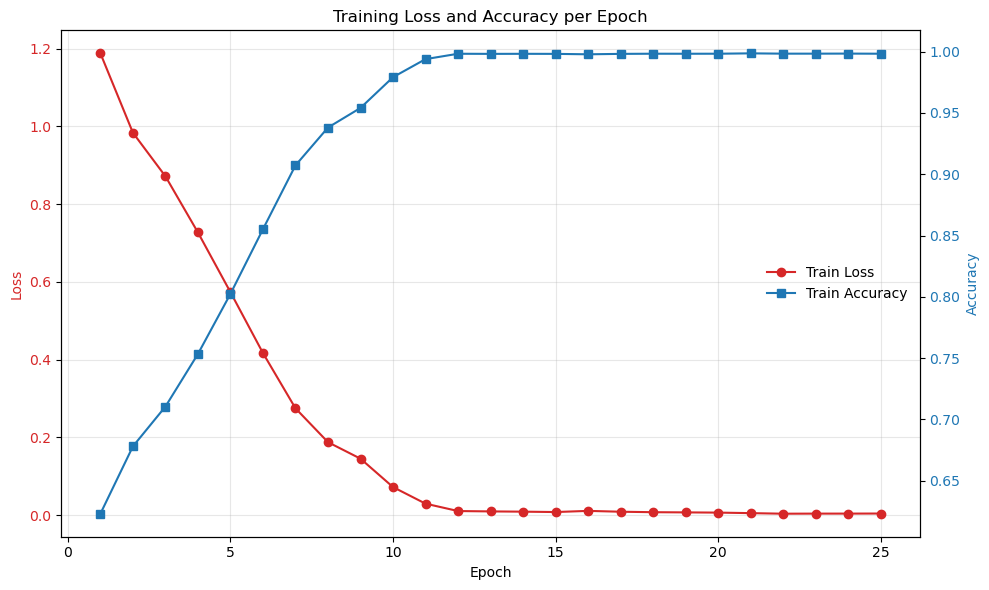

In [80]:
# Plot training loss and accuracy on the same graph (twin y-axis)
epochs = list(range(1, epochs + 1))
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(epochs, train_losses, color='tab:red', marker='o', label='Train Loss')
lns2 = ax2.plot(epochs, train_accs, color='tab:blue', marker='s', label='Train Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

lns = lns1 + lns2
labels = [l.get_label() for l in lns]
# Place legend inside the axes at the right middle so it remains within plot bounds
ax1.legend(lns, labels, loc='center right', fontsize='medium', frameon=False)
plt.title('Training Loss and Accuracy per Epoch')
# Use default tight layout (no rect) so legend stays within the plotting area
plt.tight_layout()
plt.show()

# Validation analysis using regularization and validation set

Here we use techniques like dropout and l2 regularization to tune performance on the unseen data

# Function for model evaluation

Weighted F1 score for imbalanced classes and average validation accuracy

In [82]:
# Efficient F1 evaluation for a PyTorch model (batch-wise, no grad)
from sklearn.metrics import f1_score
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def evaluate_f1(model, X_t, y_t, device=None, batch_size=1024, average='weighted'):
    """
    Evaluate a model on (X, y) and return the F1-score (sklearn) and accuracy.
    - X: torch tensor of features (dtype: float)
    - y: torch tensor of integer labels (dtype: long)
    - batch_size: evaluation batch size (large is fine)
    - average: passed to sklearn.metrics.f1_score (use 'weighted' for class imbalance)
    Returns (f1, accuracy)
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    X_t = X_t.to(device)
    y_t = y_t.to(device)
    ds = TensorDataset(X_t, y_t)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb, return_logits=True)
            # argmax over logits same argmax as if were over probs
            batch_pred = torch.argmax(logits, dim=1).cpu().numpy()
            preds.append(batch_pred)
            targets.append(yb.cpu().numpy())
            
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    f1 = f1_score(targets, preds, average=average)
    acc = (preds == targets).mean()
    return f1, acc

# Grid search for optimal hyperparameters

Tuning dropout rate and L2 alpha parameter

In [86]:
# Grid search over dropout and weight_decay, plot heatmap, save best model by val F1
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import deepcopy
import os

# Hyperparameter grids
dropouts = np.linspace(0.0, 0.6, 7)   # 0.0, 0.1, ..., 0.6
# include the unregularized model (weight_decay = 0.0) plus a log-spaced sweep
weight_decays = np.concatenate(([0.0], np.logspace(-6, -2, 5)))  # [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

# Training settings (keep small for quicker tuning; increase for final runs)
epochs_per_trial = 30
batch_size = 256
lr = 0.001

def build_model(input_dim, output_dim, hidden_dims, dropout, weight_decay=0.0):
	"""Helper: factory that builds a FeedForwardNet with dropout."""
	model = FeedForwardNet(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, dropout=dropout)
	print(model)

	# Loss, optimizer, scheduler
	loss_fn = torch.nn.CrossEntropyLoss()
     
	# Adam optimizer with L2 Regularization
	optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

	# Use to decay learning rate every {step_size} epochs - promotes stable training, and convergence to global minima
	# Halve the lr every 6 epochs
	scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

	return {'model': model, 'loss_fn': loss_fn, 'optimizer': optimizer, 'scheduler': scheduler}

# Prepare validation data tensors (reuse earlier tensors if available)
X_val = split_data['X_val']
y_val = split_data['y_val']
X_train = split_data['X_train']
y_train = split_data['y_train']

input_dim = X_train.shape[1]
output_dim = int(np.max(y_train) + 1)
hidden_dims = [2*input_dim, 2*input_dim]  # same architecture as training cell

results = np.zeros((len(weight_decays), len(dropouts)))
best_f1 = -1.0
best_meta = None
best_model_state = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device for grid search:', device)

for i, wd in enumerate(weight_decays):
    for j, do in enumerate(dropouts):
        print(f'Trial weight_decay={wd:.0e}, dropout={do:.2f}')
        # build fresh model
        model = build_model(input_dim, output_dim, hidden_dims, dropout=do, weight_decay=wd)
        
        net = model['model']
        net.to(device)
        scheduler = model['scheduler']
        optimizer = model['optimizer']
        loss_fn = model['loss_fn']
        
        # prepare dataloader
        X_tr_t = torch.from_numpy(np.asarray(X_train)).float()
        y_tr_t = torch.from_numpy(np.asarray(y_train)).long()
        train_ds = torch.utils.data.TensorDataset(X_tr_t, y_tr_t)
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        
		# Train
        for epoch in range(epochs_per_trial):
            # Set mode
            net.train()
            running_loss = 0.0
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                logits = net(xb, return_logits=True)
                loss = loss_fn(logits, yb)
                loss.backward()
                # Gradient step not learning rate step
                optimizer.step()
                running_loss += loss.item() * xb.size(0)
                
            # Update learning rate
            scheduler.step()
            
        # Evaluate on validation set
        X_val_t = torch.from_numpy(np.asarray(X_val)).float()
        y_val_t = torch.from_numpy(np.asarray(y_val)).long()
        
        f1, acc = evaluate_f1(net, X_val_t, y_val_t, device=device, batch_size=1024, average='weighted')
        results[i, j] = f1
        print(f'  val_f1={f1:.4f} val_acc={acc:.4f}')
        # checkpoint best
        if f1 > best_f1:
            best_f1 = f1
            best_meta = dict(weight_decay=wd, dropout=do)
            best_model_state = deepcopy(model['model'].state_dict())
            # save immediately
            torch.save({'model_state_dict': best_model_state, 'meta': best_meta}, 'best_model_val_f1.pth')

Device for grid search: cpu
Trial weight_decay=0e+00, dropout=0.00
FeedForwardNet(
  (net): Sequential(
    (0): Linear(in_features=518, out_features=1036, bias=True)
    (1): Swish()
    (2): Linear(in_features=1036, out_features=1036, bias=True)
    (3): Swish()
    (4): Linear(in_features=1036, out_features=16, bias=True)
  )
)
  val_f1=0.5934 val_acc=0.6154
Trial weight_decay=0e+00, dropout=0.10
FeedForwardNet(
  (net): Sequential(
    (0): Linear(in_features=518, out_features=1036, bias=True)
    (1): Swish()
    (2): Dropout(p=0.09999999999999999, inplace=False)
    (3): Linear(in_features=1036, out_features=1036, bias=True)
    (4): Swish()
    (5): Dropout(p=0.09999999999999999, inplace=False)
    (6): Linear(in_features=1036, out_features=16, bias=True)
  )
)
  val_f1=0.5942 val_acc=0.6169
Trial weight_decay=0e+00, dropout=0.20
FeedForwardNet(
  (net): Sequential(
    (0): Linear(in_features=518, out_features=1036, bias=True)
    (1): Swish()
    (2): Dropout(p=0.1999999999999

# Plot hyperparam grid

In [88]:
results

array([[0.59340188, 0.59418561, 0.60162366, 0.60174237, 0.60852175,
        0.60860356, 0.61152125],
       [0.5887915 , 0.59470743, 0.60188709, 0.60292111, 0.60411929,
        0.60510747, 0.6071578 ],
       [0.58894091, 0.58775317, 0.59630318, 0.6062843 , 0.60329915,
        0.60756652, 0.61244744],
       [0.58946108, 0.59690889, 0.59815875, 0.59613394, 0.60049185,
        0.60574121, 0.60878066],
       [0.59265371, 0.61018744, 0.61582254, 0.62165362, 0.61808842,
        0.61979757, 0.62295501],
       [0.60041185, 0.59772656, 0.59448557, 0.59257845, 0.58695095,
        0.58961446, 0.58778709]])

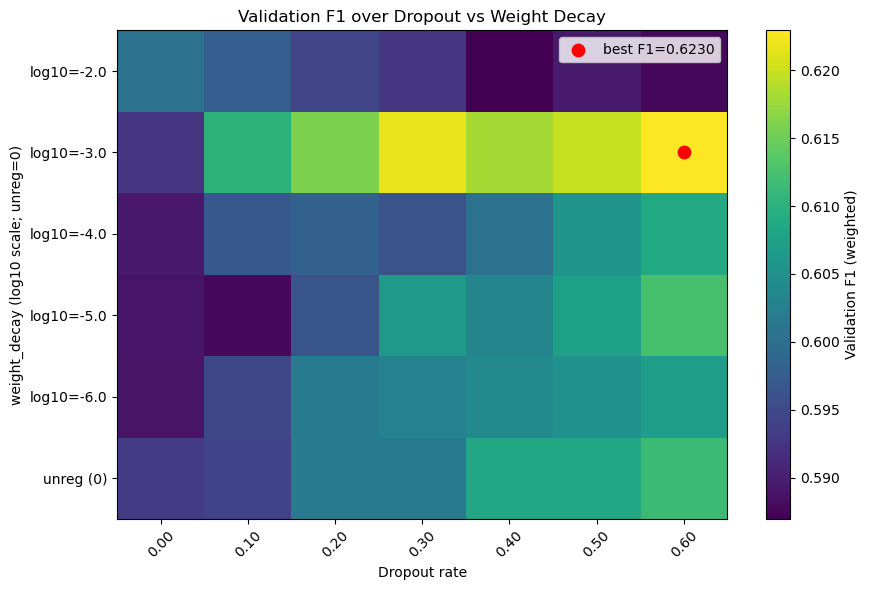

Best val F1: 0.6229550137115354
Best hyperparameters: {'weight_decay': np.float64(0.001), 'dropout': np.float64(0.6)}
Best model saved to 'best_model_val_f1.pth'


In [89]:
# Plot heatmap: use matrix indices for axes and label ticks (avoid log10(0))
plt.figure(figsize=(9,6))
im = plt.imshow(results, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Validation F1 (weighted)')

# X axis: dropout indices -> label with dropout values
xticks = np.arange(len(dropouts))
xticklabels = [f"{d:.2f}" for d in dropouts]
plt.xticks(xticks, xticklabels, rotation=45)
plt.xlabel('Dropout rate')

# Y axis: weight_decay indices -> label with log10 except handle 0.0 as 'unreg (0)'
yticks = np.arange(len(weight_decays))
ylabels = []
for wd in weight_decays:
    if wd == 0.0:
        ylabels.append('unreg (0)')
    else:
        ylabels.append(f"log10={np.log10(wd):.1f}")
plt.yticks(yticks, ylabels)
plt.ylabel('weight_decay (log10 scale; unreg=0)')
plt.title('Validation F1 over Dropout vs Weight Decay')

# Mark best if available (use grid indices)
if best_meta is not None:
    try:
        best_i = weight_decays.tolist().index(best_meta['weight_decay'])
        best_j = list(dropouts).index(best_meta['dropout'])
        plt.scatter(best_j, best_i, color='red', marker='o', s=80, label=f"best F1={best_f1:.4f}")
        plt.legend(loc='upper right')
    except ValueError:
        # fallback: best_meta contains a value not in the grid
        pass

plt.tight_layout()
plt.show()

print('Best val F1:', best_f1)
print('Best hyperparameters:', best_meta)
print("Best model saved to 'best_model_val_f1.pth'")